In [1]:
library(TSclust)

Loading required package: wmtsa
Loading required package: pdc
Loading required package: cluster


In [4]:
install.packages('lars', repos='https://cran.r-project.org/')

Installing package into 'C:/Users/Tom Work/Documents/R/win-library/3.3'
(as 'lib' is unspecified)


package 'lars' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Tom Work\AppData\Local\Temp\Rtmpkfn4nW\downloaded_packages


In [301]:
source("C:/Users/Tom Work/PycharmProjects/twipsy-lite/ts.R")

In [3]:
library(lars)

Loaded lars 1.2



Reference: http://www.stat.cmu.edu/~arinaldo/papers/arLasso.pdf

Lars documentation: https://cran.r-project.org/web/packages/lars/lars.pdf

In [6]:
junets = june_ts()
septts = sept_ts()

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


Transform series to make stationary

In [7]:
# difference by week, log
stationary <- function(ts){
    return (diff(log(ts),  168))
    }

In [8]:
st_j = stationary(junets)
st_s = stationary(septts)

Series without anomaly weeks:

In [9]:
s_short = st_s[(168+1):(168*3)]
j_short = st_j[1:(168*2)]

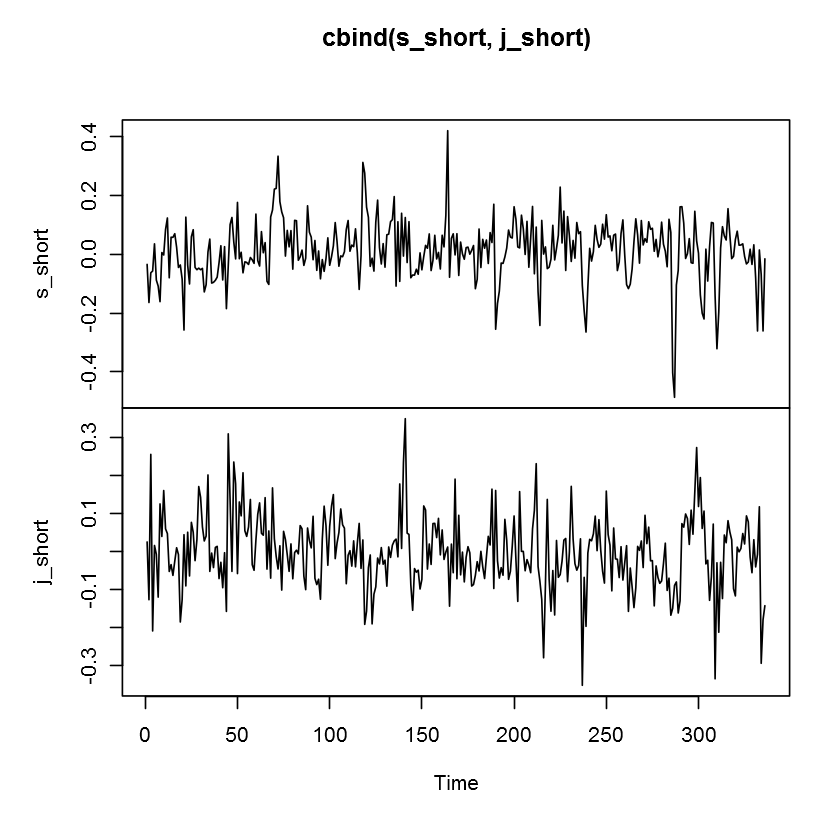

In [10]:
plot.ts(cbind(s_short, j_short))

Stationary series over month

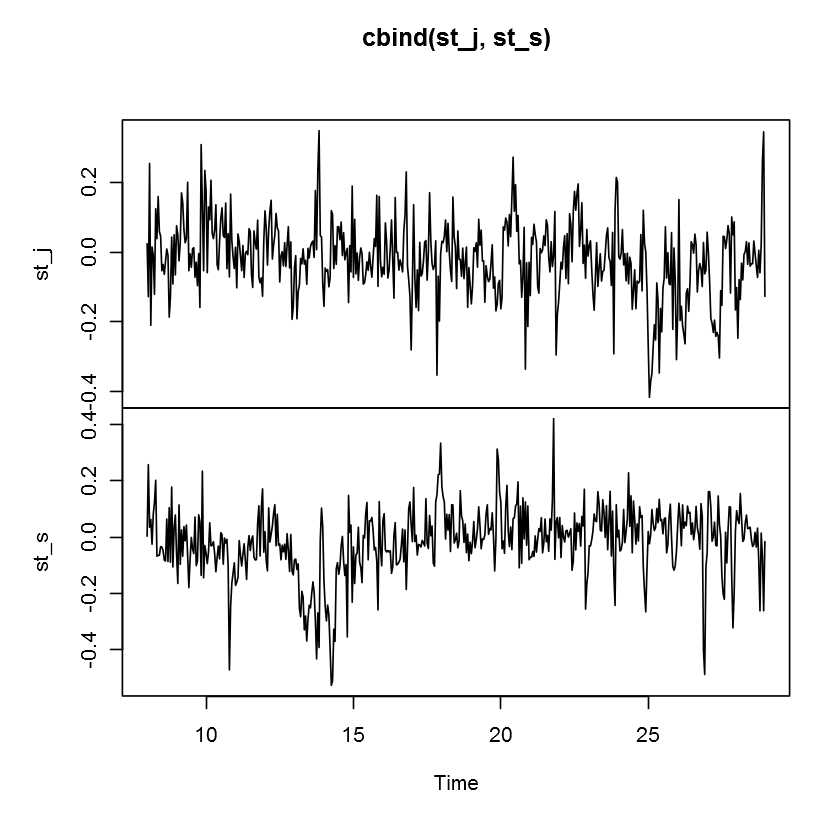

In [11]:
plot.ts(cbind(st_j, st_s))

Breakdown by week:

In [12]:
j.1 = as.numeric(window(st_j, start=c(8, 1), end=c(14, 24)))
j.2 = as.numeric(window(st_j, start=c(15, 1), end=c(21, 24)))
j.3 = as.numeric(window(st_j, start=c(22, 1), end=c(28, 24)))
s.1 = as.numeric(window(st_s, start=c(8, 1), end=c(14, 24)))
s.2 = as.numeric(window(st_s, start=c(15, 1), end=c(21, 24)))
s.3 = as.numeric(window(st_s, start=c(22, 1), end=c(28, 24)))

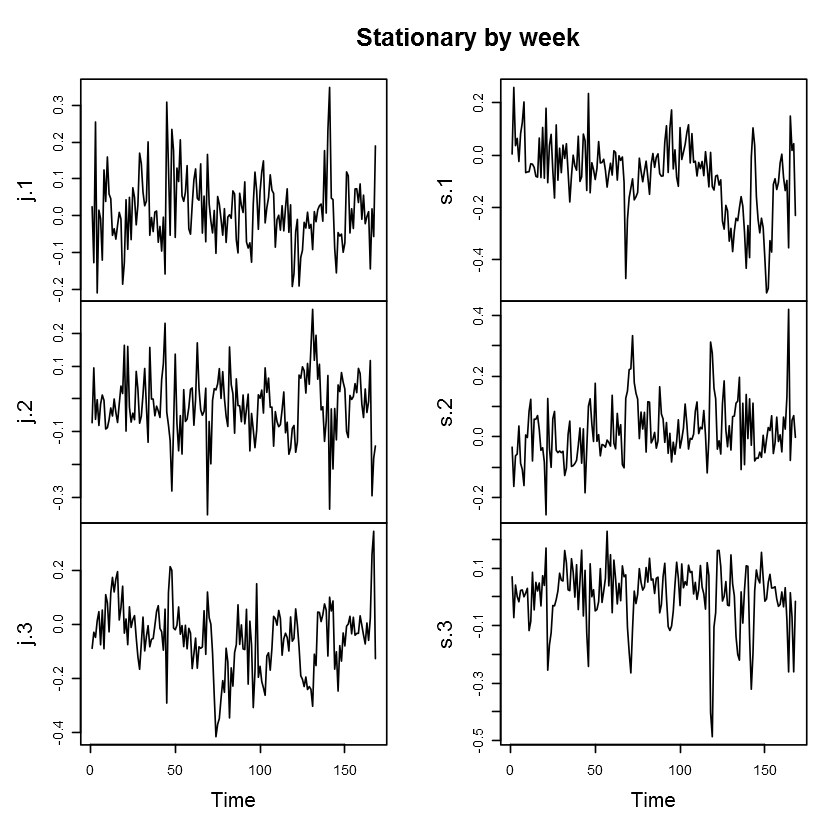

In [13]:
weeks = cbind(j.1, j.2, j.3, s.1, s.2, s.3)
plot.ts(weeks, main='Stationary by week')

In [14]:
stationary_plot <- function(){
    plot.ts(weeks, main='Stationary by week')
    }
save_png(stationary_plot, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/stationary-weeks.png')

png 
  2

PACF by week

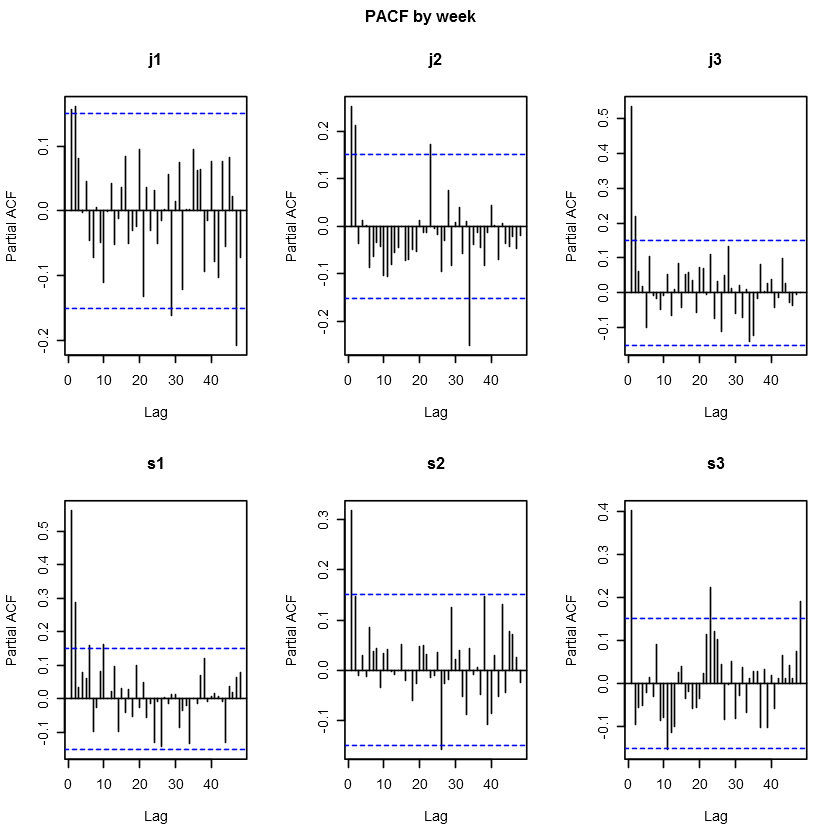

In [276]:
par(mfrow=c(2, 3), oma=c(0,0,2,0))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    
    pacf(weeks[,i], lag.max=48, main=names[i])
}
title(main='PACF by week', outer=TRUE)

In [278]:
pacf_plot <-function(){
    par(mfrow=c(2, 3), oma=c(0,0,2,0))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    
    pacf(weeks[,i], lag.max=48, main=names[i])
}
title(main='PACF by week', outer=TRUE)
}
save_png(pacf_plot, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/pacf-week.png')

png 
  2

# Lasso regression

In [162]:
install.packages("glmnet", repos = "http://cran.us.r-project.org")

Installing package into 'C:/Users/Tom Work/Documents/R/win-library/3.3'
(as 'lib' is unspecified)
also installing the dependencies 'iterators', 'foreach'



package 'iterators' successfully unpacked and MD5 sums checked
package 'foreach' successfully unpacked and MD5 sums checked
package 'glmnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Tom Work\AppData\Local\Temp\RtmpCKYT2X\downloaded_packages


Set number of lags

In [252]:
p=50

Break time series into a bunch of explanatory variables

In [123]:
ar_matrix <- function(ts, lags){
    m = matrix(ncol=lags, nrow=(length(ts)-lags))
    for (i in 1:nrow(m)){
        m[i, ] = ts[i:(i+lags-1)]
    }
    return (m)
}

In [253]:
ar_s = ar_matrix(st_j, p)

In [254]:
ar_j = ar_matrix(st_s, p)

In [255]:
ar_combined = rbind(ar_j, ar_s)

In [256]:
dim(ar_combined)

[1] 908  50

Confirm that it works...

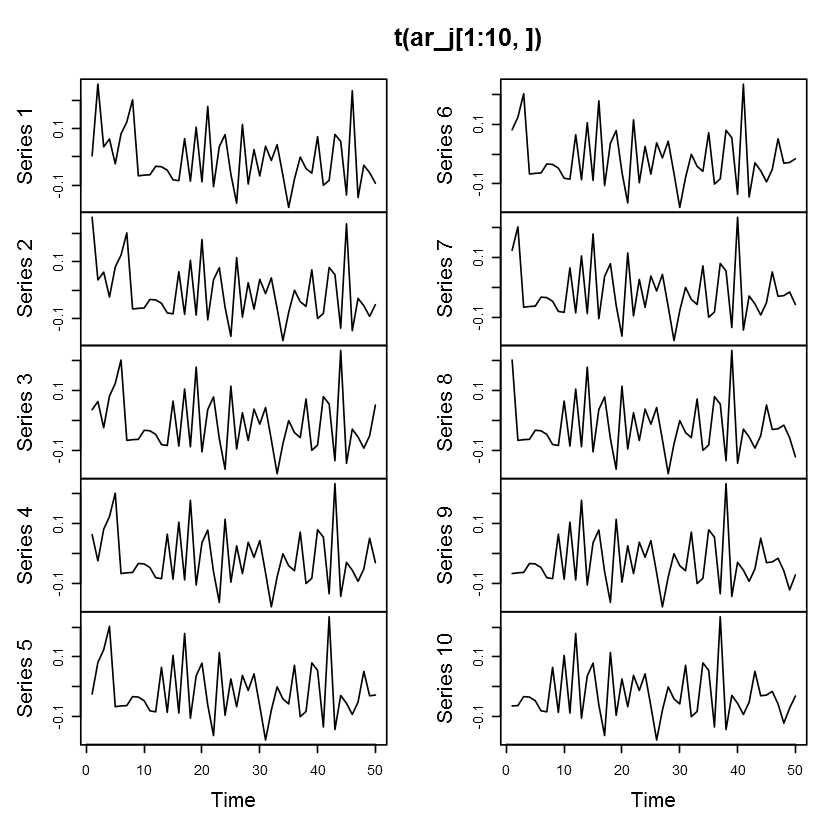

In [257]:
plot.ts(t(ar_j[1:10,]))

In [259]:
ar_y = c(st_s[(p+1):(length(st_j))], st_j[(p+1):(length(st_s))])

In [130]:
nrow(ar_combined)

[1] 908

In [131]:
length(ar_y)

[1] 908

In [132]:
ar_combined[2:nrow(ar_combined),25]-ar_y

Warning message:
In ar_combined[2:nrow(ar_combined), 25] - ar_y: longer object length is not a multiple of shorter object length

[1] -1.123480e-01  6.350016e-02 -6.543149e-02  5.414347e-02 -5.140370e-02
  [6]  9.592468e-02  1.096388e-01  1.150010e-01 -3.392315e-02 -1.025610e-01
 [11] -9.482080e-02 -1.034968e-02  5.445608e-02 -5.509804e-02  9.232913e-02
 [16] -9.327897e-02  2.102950e-02  5.506749e-01  2.997025e-01  2.726643e-02
 [21]  3.607590e-01 -5.315548e-02  1.416877e-01  1.036611e-01  4.970750e-02
 [26] -3.966147e-02  1.127045e-01  7.129333e-02  3.229440e-02  7.350544e-03
 [31]  2.564864e-02  2.749346e-02 -3.753941e-02 -3.706092e-02 -2.947961e-02
 [36]  2.512483e-02  5.002200e-03 -2.484299e-02  7.805898e-02  5.889372e-02
 [41] -5.633947e-02 -2.158125e-01 -4.044901e-01 -3.470920e-01 -3.341822e-01
 [46] -7.313384e-02 -1.106718e-01 -8.611868e-02 -4.017601e-02 -2.475430e-01
 [51]  5.039158e-03 -7.230534e-02 -1.419101e-01 -1.455359e-01 -1.387404e-01
 [56] -5.361928e-02 -2.314527e-01 -6.441542e-03  2.933480e-02  3.294997e-02
 [61]  1.933982e-02  5.640093e-02 -4.618584e-02 -2.130507e-03 -9.221324e-02
 [66]  9.614706e-02  2.331344e-01 -7.635163e-02  2.225126e-01  3.055486e-01
 [71]  2.711822e-02  9.692324e-02  2.966223e-02 -2.484233e-02  3.567256e-01
 [76]  2.654460e-01  2.027064e-01  2.526962e-01  4.136540e-01  3.949757e-01
 [81]  3.381359e-01  3.716173e-01  2.131166e-01  2.269385e-01  1.215123e-01
 [86]  1.302594e-01  1.434050e-01  2.700892e-01  3.531836e-01  2.815946e-01
 [91]  3.442175e-01 -1.127534e-01 -9.352804e-02 -1.566695e-01  2.432301e-02
 [96]  1.656841e-01  2.196576e-01  1.262137e-01  1.821364e-01  1.429451e-01
[101]  2.432235e-01  3.173513e-01  1.138007e-01  4.138820e-02 -1.675460e-01
[106] -2.781587e-01 -1.584285e-01 -1.363285e-01 -2.204752e-01 -2.044527e-01
[111] -7.413071e-02 -5.950527e-02 -1.977028e-01 -7.797320e-02 -4.175033e-01
[116] -4.089055e-01 -5.200006e-02  3.339803e-01  7.047453e-02  6.073576e-03
[121] -1.828418e-01 -2.396917e-01 -2.765202e-01 -1.888122e-01 -2.871062e-01
[126] -3.645217e-01 -5.152120e-01 -3.240536e-01 -4.546595e-01 -2.357582e-01
[131] -1.024944e-02 -1.899003e-01 -1.623766e-01 -1.003433e-01 -2.081582e-02
[136] -3.952091e-02 -9.936381e-02 -1.270964e-02 -9.593937e-02  2.207851e-02
[141]  5.476485e-02  1.444028e-01 -2.901570e-01 -1.180495e-01 -1.193417e-01
[146] -1.044986e-02 -1.005296e-02  8.820259e-02 -3.987474e-02  2.002263e-02
[151] -5.739172e-02 -1.955378e-03 -5.432718e-02  1.827110e-01  2.192589e-01
[156]  8.722130e-03  1.360818e-01  8.657960e-02  4.115368e-02  1.111653e-01
[161] -7.098285e-02  1.488556e-01 -4.473964e-02 -3.594514e-01  1.063489e-03
[166] -7.942943e-02 -8.551284e-02 -1.170809e-01  9.876986e-02 -5.184001e-02
[171]  1.053516e-02 -2.140438e-02 -2.487300e-02 -1.328547e-02 -1.173002e-01
[176] -8.507913e-02  3.891960e-02 -8.518927e-02 -7.666081e-02 -5.550088e-02
[181] -1.658813e-01 -8.297944e-02 -6.872281e-02  1.209971e-01  1.541514e-02
[186] -1.011861e-01 -3.361522e-01 -2.614281e-01 -1.228493e-01 -2.086942e-01
[191] -1.370042e-01 -1.600854e-01  5.216113e-02 -8.908441e-03 -7.449140e-02
[196] -8.848979e-02 -1.063199e-01  2.282217e-02 -1.504263e-01 -1.253039e-01
[201]  1.622540e-03 -2.224475e-02  1.226964e-01  1.636704e-02 -2.679460e-02
[206] -8.808416e-02 -7.016869e-02 -1.870031e-02 -7.337685e-02 -1.497798e-01
[211]  1.819191e-01  1.397230e-01  3.054360e-01  2.423097e-01  3.922080e-01
[216]  1.939375e-01  8.836658e-02  1.619943e-01  2.393572e-03  5.285927e-02
[221] -8.265029e-02  3.783307e-02 -9.966622e-03  1.213036e-01  1.226745e-01
[226] -2.906656e-02 -9.298012e-02 -1.007661e-01 -4.825319e-02 -4.464965e-02
[231]  1.393234e-01 -1.135717e-02  5.322070e-02  1.010582e-01  5.248730e-02
[236] -3.675862e-01 -2.650046e-01 -2.440773e-01 -1.439866e-01 -1.710086e-02
[241] -1.542991e-03  1.132647e-01 -1.467128e-01 -1.929942e-01  5.545985e-03
[246]  1.411170e-01  6.443564e-03  3.297015e-03 -7.212945e-02 -7.672277e-02
[251] -1.023775e-01 -3.360059e-02 -8.146130e-02  1.188985e-01 -7.939515e-02
[256]  1.182884e-01 -5.305912e-02  1.138129e-02 -2.448685e-01  2.268446e-02
[261]  2.017982e-01  3.563133e-01  2.309958e-01  1

In [133]:
ar_combined[,25]

[1] -0.0611925259 -0.1639928164  0.1148173751 -0.0960396202  0.0259637616
  [6] -0.0673374132  0.0377823659 -0.0126358913  0.0431176225 -0.0652195620
 [11] -0.1789667166 -0.0785933149 -0.0006326808 -0.0410604148 -0.0578095692
 [16]  0.0717427540 -0.1006063741 -0.0830995145  0.0798053753  0.0547004503
 [21] -0.1350804064  0.2346535860 -0.1439602013 -0.0294319768 -0.0557822165
 [26] -0.0933615769 -0.0516448180  0.0513172196 -0.0306081303 -0.0281797105
 [31] -0.0159337140 -0.0581423165 -0.1222747295 -0.0718833699 -0.0312964082
 [36] -0.0764056680  0.0162274807  0.0097169945 -0.0955164984 -0.0027115315
 [41] -0.0205863742 -0.0073274064 -0.1041290162 -0.4708695697 -0.2450020069
 [46] -0.1623468345 -0.1261054138 -0.0908047206 -0.1711196295 -0.1594433591
 [51] -0.1430690748 -0.0119833516 -0.0613872927 -0.1019014640 -0.0604741123
 [56] -0.0232842576 -0.0837909524 -0.1497681906 -0.0343439561  0.0057645155
 [61] -0.0469260568 -0.0088973470  0.0047147941 -0.0706735068 -0.0807705147
 [66] -0.0794800968  0.0490120634  0.1116835088 -0.0663794570  0.1020900246
 [71]  0.1718353330 -0.0529715751  0.0198670998 -0.0850009503 -0.1192673446
 [76]  0.1044739193 -0.0170225097  0.0109180473  0.0400085897  0.0850617414
 [81]  0.1154561738 -0.0301716727  0.0816845085 -0.0279024144 -0.0235702805
 [86] -0.0798760261 -0.0282371625 -0.0516861323 -0.0244876711 -0.0786400081
 [91]  0.0127331465 -0.0471349935 -0.1214508417  0.0099721690 -0.1204226080
 [96] -0.1337132280 -0.0800897976 -0.0770561452 -0.1146631763 -0.0944250182
[101] -0.2522517013 -0.2824684823 -0.1917883284 -0.2126875667 -0.3285923037
[106] -0.2795195244 -0.3683076208 -0.2899328107 -0.2410190060 -0.2505087428
[111] -0.2013883463 -0.1584966107 -0.1950911550 -0.2945769159 -0.4318236122
[116] -0.2688614731 -0.3913524468 -0.0086974087  0.1035002047  0.0362469343
[121] -0.1580362371 -0.2457738885 -0.2967137211 -0.2408768440 -0.2765614032
[126] -0.3951967645 -0.5256920015 -0.5091395921 -0.3264882476 -0.3699805068
[131] -0.1119735268 -0.0901488787 -0.1315043327 -0.1046905354 -0.0300334935
[136]  0.0030643875 -0.0843659033 -0.1355858858 -0.0968740904 -0.3538504107
[141]  0.1486417916  0.0175530858  0.0433026465 -0.2304800926 -0.0342275940
[146] -0.1641098129 -0.0629320821 -0.0570220148  0.0356433600 -0.0877491540
[151] -0.1080905339 -0.1611703056  0.0060724181 -0.0024346798  0.0846790072
[156]  0.1237847059 -0.0798994376  0.0583959817  0.0576860590  0.0703098323
[161]  0.0238802075 -0.0448449919 -0.0362220750 -0.0841644519 -0.2579110428
[166]  0.1265632845 -0.0372117624 -0.1011001494  0.0596769373  0.0838219501
[171] -0.0447680919 -0.0524822222 -0.0469690525 -0.0525592282 -0.0478744119
[176] -0.1281131622 -0.1037785816  0.0080277958  0.0518925007 -0.0980320327
[181] -0.0954741803 -0.0886215681 -0.0776858000 -0.0288935444  0.0291561527
[186] -0.0872850460  0.0261378606 -0.1850776698 -0.0394248156  0.1015403579
[191]  0.1254997950  0.0422176675 -0.0155873124  0.1767578661 -0.0149479079
[196]  0.0070719198 -0.0630173818 -0.0255646705 -0.0276862292 -0.0345889388
[201] -0.0108129395 -0.0186994532 -0.0308918034  0.1370817705 -0.0213712181
[206] -0.0399732980  0.0772597030  0.0052936386  0.0398292691 -0.0918409362
[211] -0.1027001874  0.1273239576  0.1510745613  0.2220032998  0.2243896106
[216]  0.3341939873  0.1792218338  0.1444981313  0.1245967345 -0.0060394666
[221]  0.0815633177  0.0254724076  0.0807552276 -0.0505084029  0.1158373332
[226]  0.1144909277 -0.0203219931 -0.0086470497  0.0143853265 -0.0377382593
[231] -0.0131787013  0.1653438670  0.0754623268  0.0585295779 -0.0184640885
[236]  0.0470796054 -0.0545951271  0.0113515562 -0.0834326644 -0.0179200516
[241] -0.0580139916 -0.0147156468  0.0561315490 -0.0373975640 -0.0084330384
[246]  0.0287040441  0.1081226955  0.0429221535 -0.0405417806 -0.0054662852
[251] -0.0081835593  0.0087445699  0.0843330716  0.1151513828  0.0105149261
[256]  0.0314709510  0.0260204475  0.0868194961  0.0053088773 -0.1195222463
[261] -0.0054076958  0.3129910305  0.2763561777  0

In [134]:
ar_y

[1] -0.0516448180  0.0513172196 -0.0306081303 -0.0281797105 -0.0159337140
  [6] -0.0581423165 -0.1222747295 -0.0718833699 -0.0312964082 -0.0764056680
 [11]  0.0162274807  0.0097169945 -0.0955164984 -0.0027115315 -0.0205863742
 [16] -0.0073274064 -0.1041290162 -0.4708695697 -0.2450020069 -0.1623468345
 [21] -0.1261054138 -0.0908047206 -0.1711196295 -0.1594433591 -0.1430690748
 [26] -0.0119833516 -0.0613872927 -0.1019014640 -0.0604741123 -0.0232842576
 [31] -0.0837909524 -0.1497681906 -0.0343439561  0.0057645155 -0.0469260568
 [36] -0.0088973470  0.0047147941 -0.0706735068 -0.0807705147 -0.0794800968
 [41]  0.0490120634  0.1116835088 -0.0663794570  0.1020900246  0.1718353330
 [46] -0.0529715751  0.0198670998 -0.0850009503 -0.1192673446  0.1044739193
 [51] -0.0170225097  0.0109180473  0.0400085897  0.0850617414  0.1154561738
 [56] -0.0301716727  0.0816845085 -0.0279024144 -0.0235702805 -0.0798760261
 [61] -0.0282371625 -0.0516861323 -0.0244876711 -0.0786400081  0.0127331465
 [66] -0.0471349935 -0.1214508417  0.0099721690 -0.1204226080 -0.1337132280
 [71] -0.0800897976 -0.0770561452 -0.1146631763 -0.0944250182 -0.2522517013
 [76] -0.2824684823 -0.1917883284 -0.2126875667 -0.3285923037 -0.2795195244
 [81] -0.3683076208 -0.2899328107 -0.2410190060 -0.2505087428 -0.2013883463
 [86] -0.1584966107 -0.1950911550 -0.2945769159 -0.4318236122 -0.2688614731
 [91] -0.3913524468 -0.0086974087  0.1035002047  0.0362469343 -0.1580362371
 [96] -0.2457738885 -0.2967137211 -0.2408768440 -0.2765614032 -0.3951967645
[101] -0.5256920015 -0.5091395921 -0.3264882476 -0.3699805068 -0.1119735268
[106] -0.0901488787 -0.1315043327 -0.1046905354 -0.0300334935  0.0030643875
[111] -0.0843659033 -0.1355858858 -0.0968740904 -0.3538504107  0.1486417916
[116]  0.0175530858  0.0433026465 -0.2304800926 -0.0342275940 -0.1641098129
[121] -0.0629320821 -0.0570220148  0.0356433600 -0.0877491540 -0.1080905339
[126] -0.1611703056  0.0060724181 -0.0024346798  0.0846790072  0.1237847059
[131] -0.0798994376  0.0583959817  0.0576860590  0.0703098323  0.0238802075
[136] -0.0448449919 -0.0362220750 -0.0841644519 -0.2579110428  0.1265632845
[141] -0.0372117624 -0.1011001494  0.0596769373  0.0838219501 -0.0447680919
[146] -0.0524822222 -0.0469690525 -0.0525592282 -0.0478744119 -0.1281131622
[151] -0.1037785816  0.0080277958  0.0518925007 -0.0980320327 -0.0954741803
[156] -0.0886215681 -0.0776858000 -0.0288935444  0.0291561527 -0.0872850460
[161]  0.0261378606 -0.1850776698 -0.0394248156  0.1015403579  0.1254997950
[166]  0.0422176675 -0.0155873124  0.1767578661 -0.0149479079  0.0070719198
[171] -0.0630173818 -0.0255646705 -0.0276862292 -0.0345889388 -0.0108129395
[176] -0.0186994532 -0.0308918034  0.1370817705 -0.0213712181 -0.0399732980
[181]  0.0772597030  0.0052936386  0.0398292691 -0.0918409362 -0.1027001874
[186]  0.1273239576  0.1510745613  0.2220032998  0.2243896106  0.3341939873
[191]  0.1792218338  0.1444981313  0.1245967345 -0.0060394666  0.0815633177
[196]  0.0254724076  0.0807552276 -0.0505084029  0.1158373332  0.1144909277
[201] -0.0203219931 -0.0086470497  0.0143853265 -0.0377382593 -0.0131787013
[206]  0.1653438670  0.0754623268  0.0585295779 -0.0184640885  0.0470796054
[211] -0.0545951271  0.0113515562 -0.0834326644 -0.0179200516 -0.0580139916
[216] -0.0147156468  0.0561315490 -0.0373975640 -0.0084330384  0.0287040441
[221]  0.1081226955  0.0429221535 -0.0405417806 -0.0054662852 -0.0081835593
[226]  0.0087445699  0.0843330716  0.1151513828  0.0105149261  0.0314709510
[231]  0.0260204475  0.0868194961  0.0053088773 -0.1195222463 -0.0054076958
[236]  0.3129910305  0.2763561777  0.1606446676  0.1260665879 -0.0409131293
[241] -0.0131726557 -0.0571331300  0.1093152677  0.1845611134  0.0231580588
[246] -0.0329942700  0.0364785895 -0.0438387959  0.0666631694  0.0685392113
[251]  0.1111220215  0.1179336598  0.1966126844 -0.1083835276  0.1108661007
[256] -0.0922679090  0.1398786196 -0.0060724109  0.1253462781 -0.0280921562
[261]  0.1111928108 -0.0799571707 -0.0703511319 -0

In [264]:
cv_plot <- function(){
    cv.lars(ar_combined, ar_y, K=10, type='lasso', mode='step')
    title(main='June and September combined LARS Cross validation')
}
save_png(cv_plot, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/lars-cv.png')

png 
  2

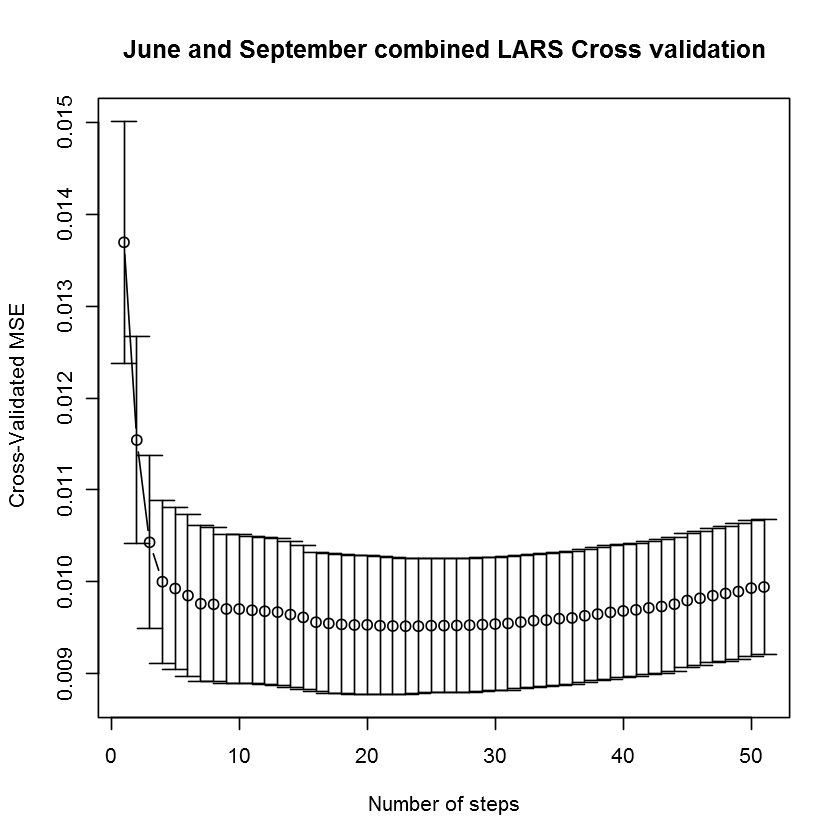

In [260]:
cv.res = cv.lars(ar_combined, ar_y, K=10, type='lasso', mode='step')
title(main='June and September combined LARS Cross validation')

In [235]:
fit= lars(ar_combined, ar_y, normalize=FALSE)
predict.lars(reg, s=0.18, type='coefficients', mode='fraction')$coefficients

[1]  0.000000000  0.042645650  0.215027007  0.000000000  0.000000000
 [6]  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000
[11]  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000
[16]  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000
[21]  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000
[26]  0.036375796  0.049516605  0.115055150  0.000000000  0.000000000
[31]  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000
[36]  0.000000000  0.000000000  0.000000000 -0.035761855 -0.021076829
[41]  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000
[46]  0.000000000  0.000000000 -0.003343565  0.000000000  0.210631806

In [265]:
# matrix of regression parameters
mreg = matrix(nrow=p, ncol=6)
for (i in 1:6){
    # create regression matrix matrix
    arm = ar_matrix(weeks[,i], p)
    
    # get regression coefficient (s= number of steps in lars i.e. number of coefficients in ar model)
#     cv.res = cv.lars(arm, weeks[(p+1):length(s.1), i], K=20, plot=FALSE)
#     opt.frac = min(cv.res$cv) + sd(cv.res$cv)
    reg = lars(arm, weeks[(p+1):length(s.1),i], normalize=FALSE)
#     mreg[,i] = predict.lars(reg, s=cv.res, type='coefficients', mode='fraction')$coefficients
    mreg[,i] = predict.lars(reg, s=4, type='coefficients', mode='step')$coefficients
#     mreg[,i] = predict.lars(reg, s=0.2, type='coefficients', mode='fraction')$coefficients
    # plot cross validated mse
#     cv.lars(arm, weeks[(p+1):length(s.1), i], K=20)
}

In [272]:
lasso_plot <- function(){
reversed = apply(mreg, 2, rev)
par(mfrow = c(3,2), oma=c(0,0,2,0))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    bp=barplot(reversed[,i], xlab='lag', ylab='coef', main=names[i])
    axis(1,at=bp, labels= c(1:p))
    }
title(main='Lasso AR Coefficients', outer=TRUE)
}
save_png(lasso_plot, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/lasso-coef.png')

png 
  2

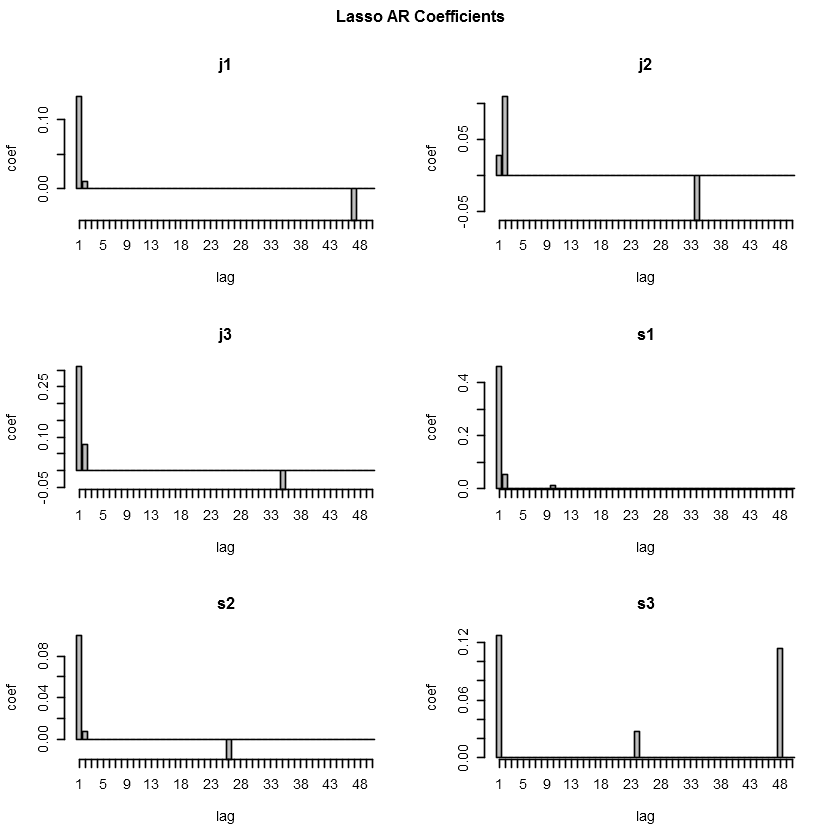

In [271]:
reversed = apply(mreg, 2, rev)
par(mfrow = c(3,2), oma=c(0,0,2,0))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    bp=barplot(reversed[,i], xlab='lag', ylab='coef', main=names[i])
    axis(1,at=bp, labels= c(1:p))
    }
title(main='Lasso AR Coefficients', outer=TRUE)

# Y-W AR by AIC

In [15]:
mar = matrix(nrow=25, ncol=6)
for (i in 1:6){
    armodel = c(ar(weeks[,i], order.max=25)$ar, rep(0, 25))[1:25]
    mar[,i] = armodel
    }

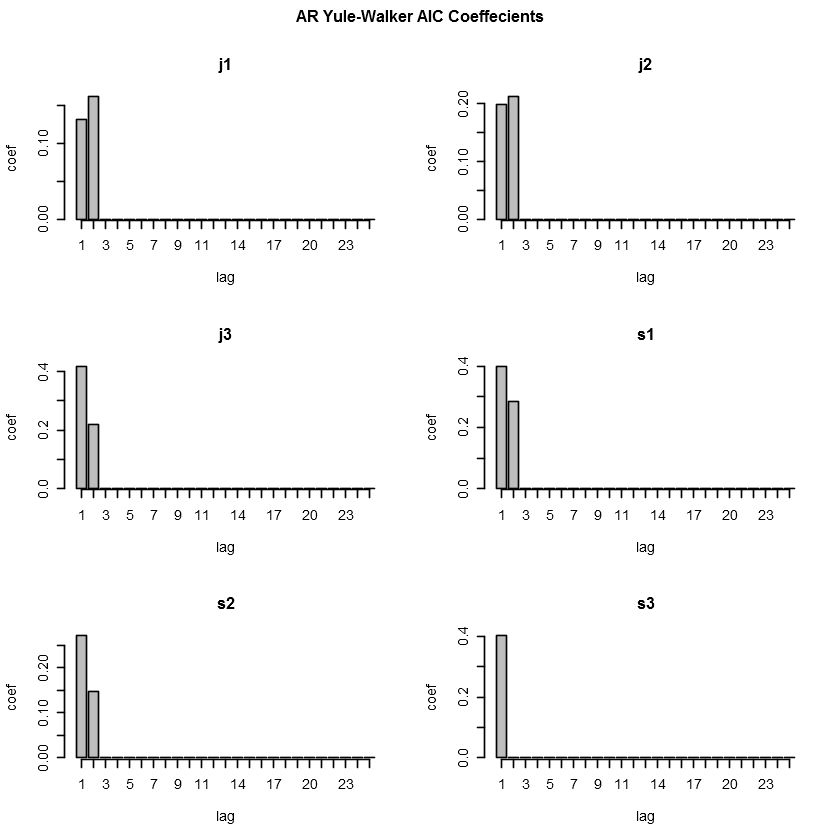

In [22]:
par(mfrow = c(3,2), oma=c(0,0,2,0))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    
    bp=barplot(mar[,i], xlab='lag', ylab='coef', main=names[i])
    
    axis(1,at=bp, labels= c(1:25))
    }
title(main='AR Yule-Walker AIC Coeffecients', outer=TRUE)

In [23]:
plot_aic <-function(){
par(mfrow = c(3,2), oma=c(0,0,2,0))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    bp=barplot(mar[,i], xlab='lag', ylab='coef', main=names[i])
    axis(1,at=bp, labels= c(1:25))
    }
title(main='AR Yule-Walker AIC Coeffecients', outer=TRUE)
}

save_png(plot_aic, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/ar-aic-weeks.png')

png 
  2

# Clustering

l2 between lasso ar coef

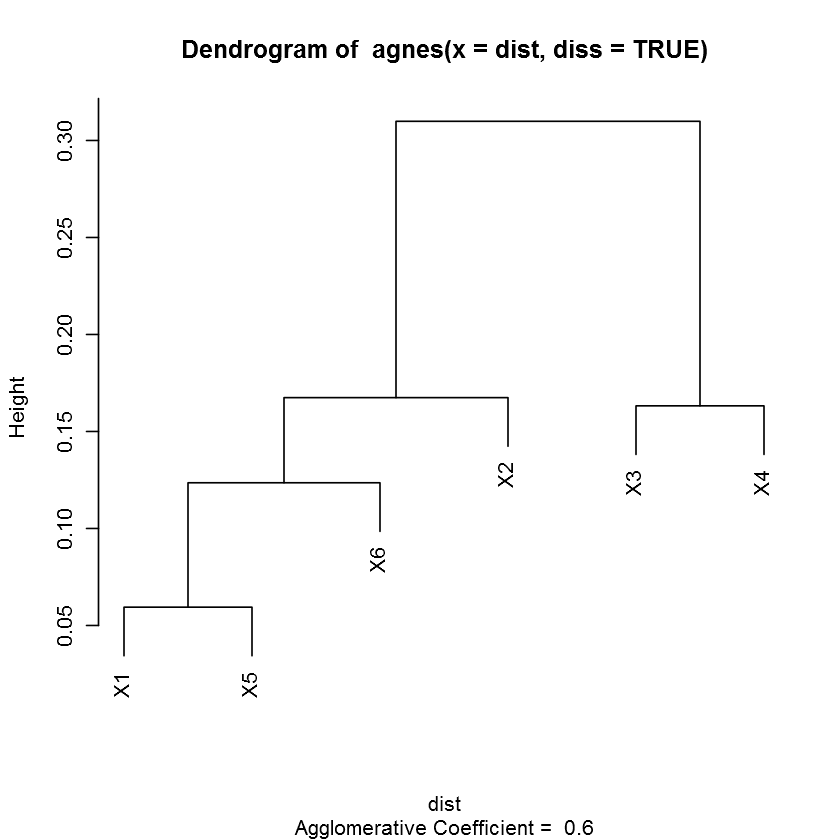

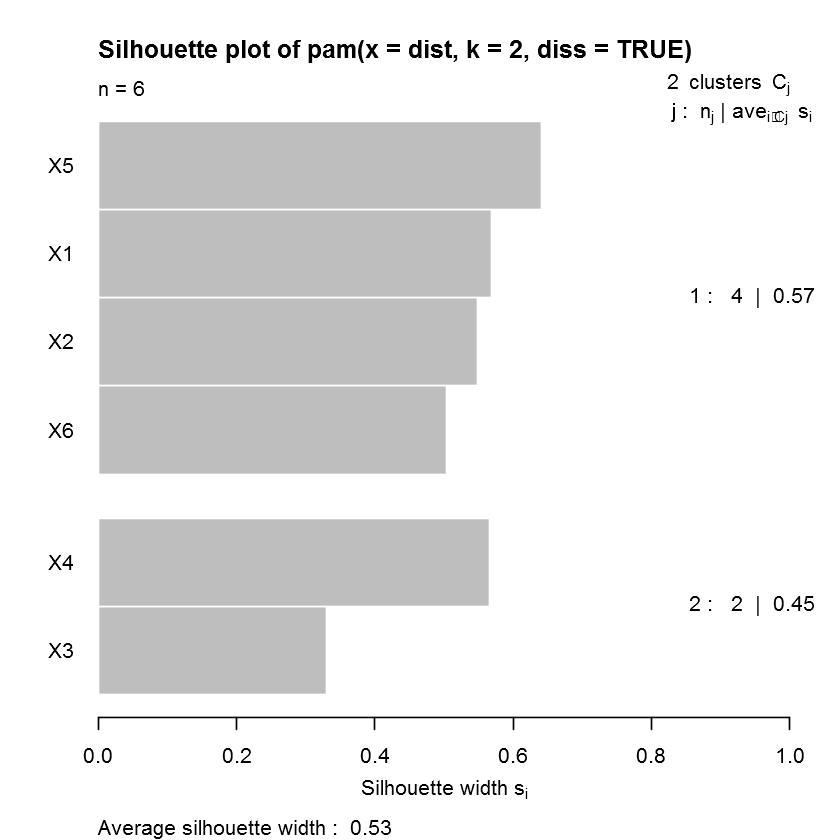

In [302]:
dist = diss(data.frame(mreg), METHOD='EUCL')
clust(dist)

In [307]:
plot_lasso_clust <- function(){
    par(mfrow=c(2,1))
    names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
    colnames(mreg)=names
    dist = diss(data.frame(mreg), METHOD='EUCL')
    

    clust(dist)
}
save_png(plot_lasso_clust, 'C:/users/tom work/pycharmprojects/twipsy-lite/plots/clustering/lasso-clust.png')

png 
  2

l2 dist between y-w aic ar

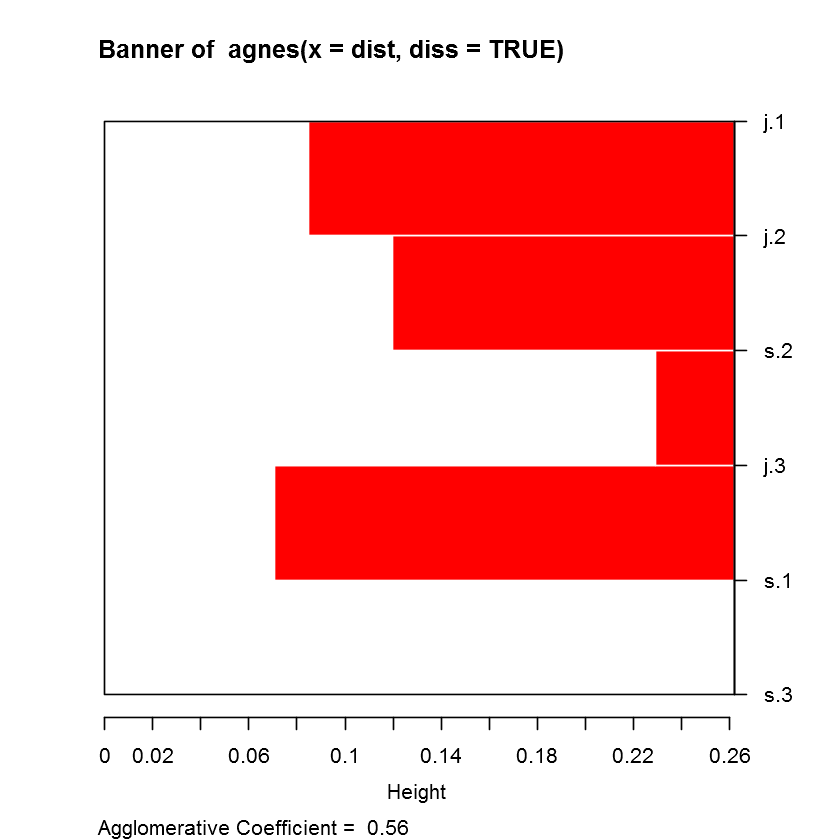

j.1 j.2 j.3 s.1 s.2 s.3 
  1   1   2   2   1   1 


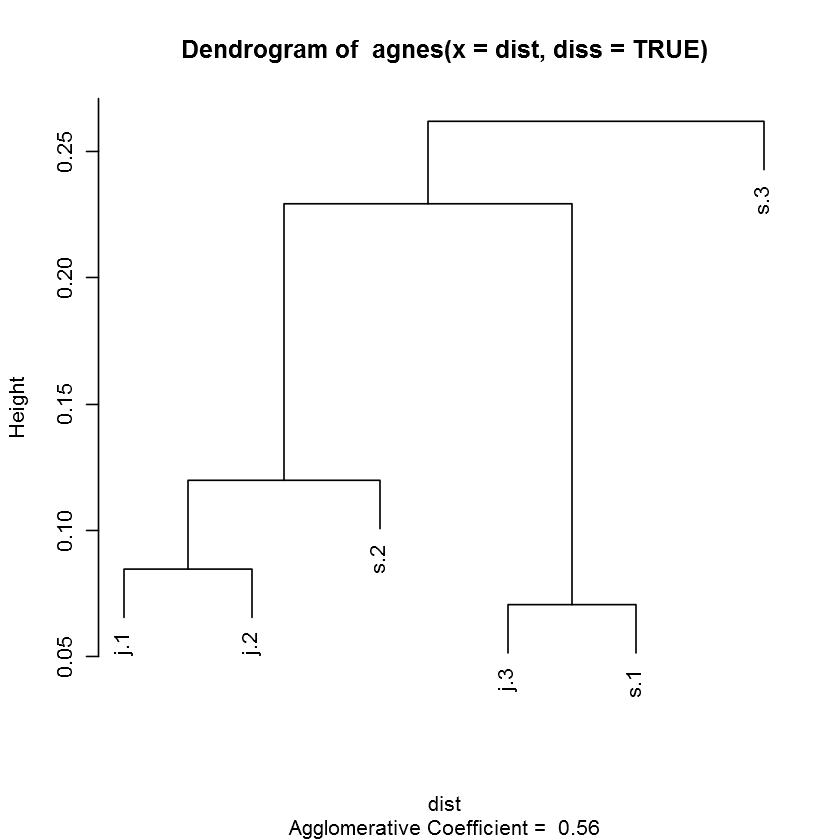

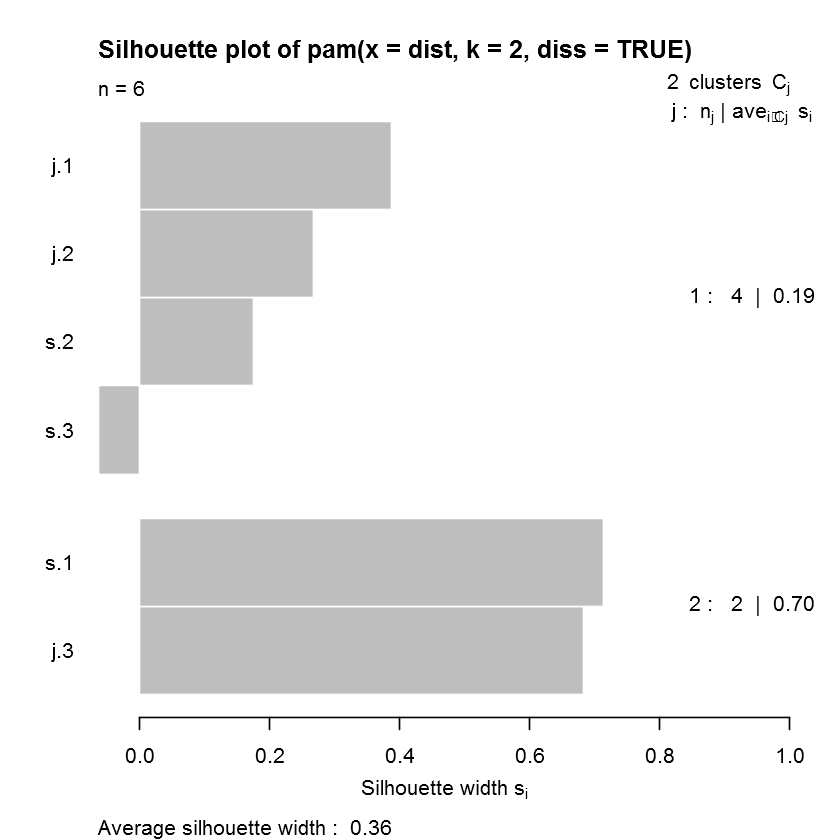

In [292]:
dist = diss(data.frame(weeks), METHOD='AR.PIC')
clust(dist)

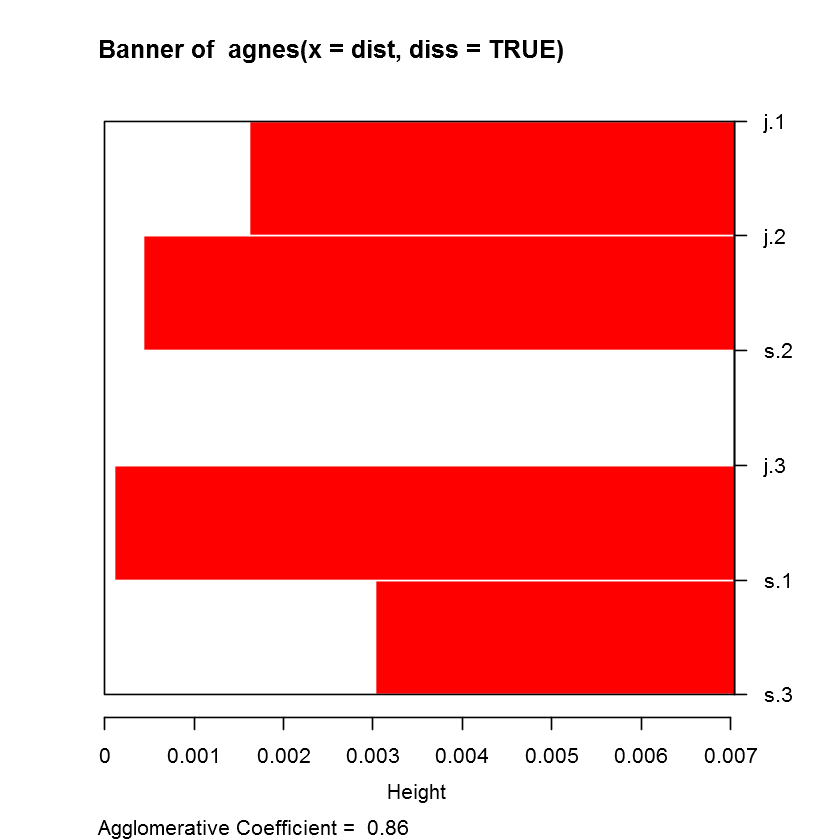

j.1 j.2 j.3 s.1 s.2 s.3 
  1   1   2   2   1   1 


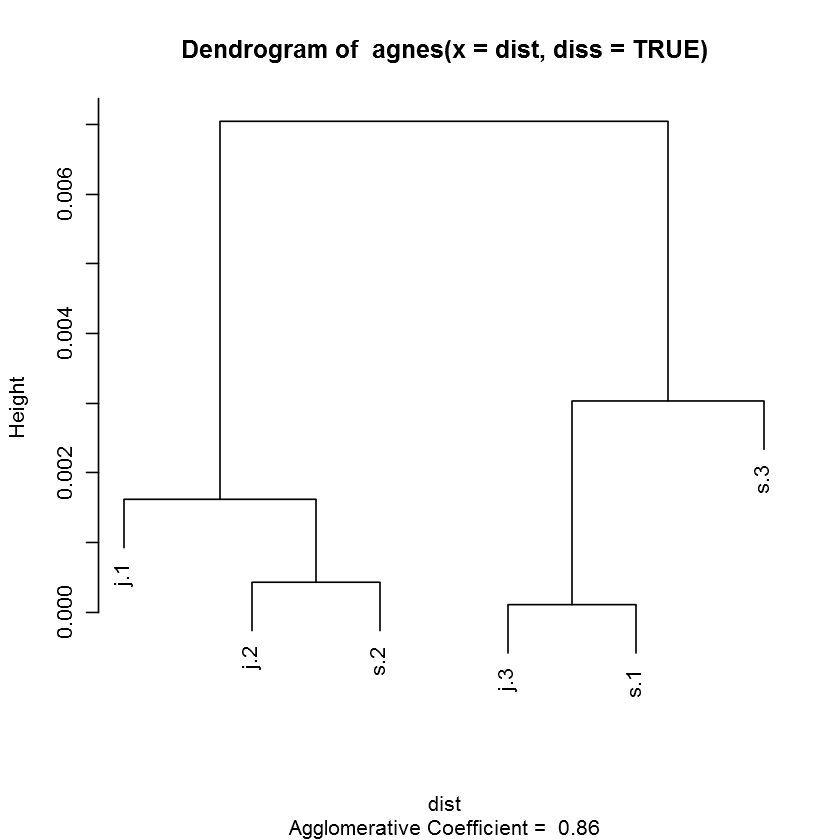

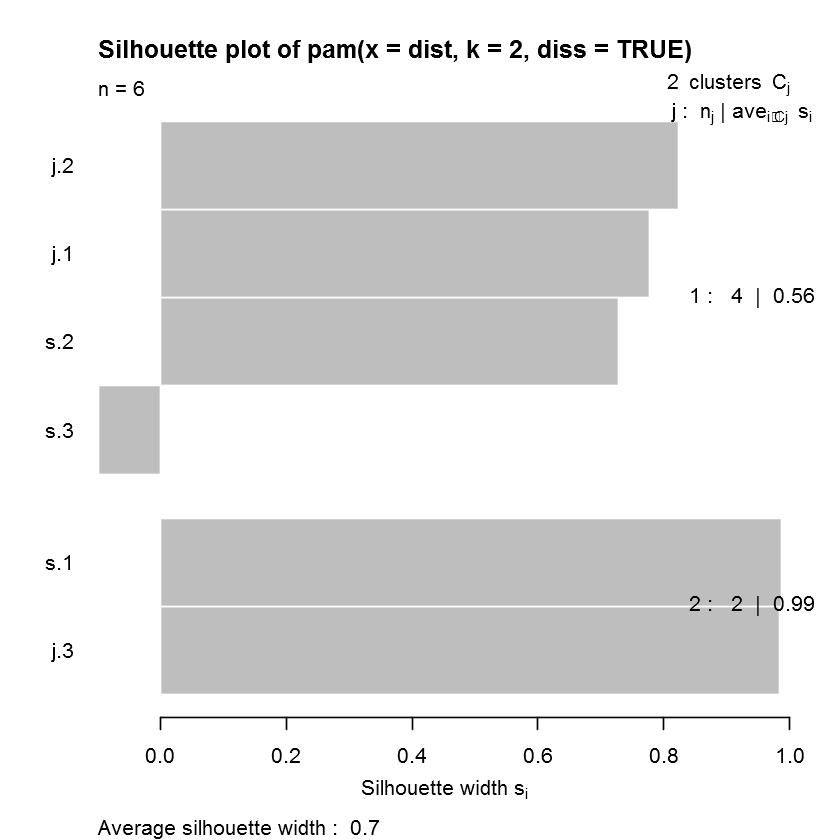

In [293]:
dist = diss(data.frame(weeks), METHOD='PACF', lag.max=25, p=0.9)
clust(dist)